In [1]:
import numpy as np

from scipy import stats

In [2]:
%matplotlib inline

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams['axes.prop_cycle'] = plt.style.library['seaborn-deep']['axes.prop_cycle']

# Decide if KDE smoothing from a discrete distribution  improves the PMF match

0.99889092813258085

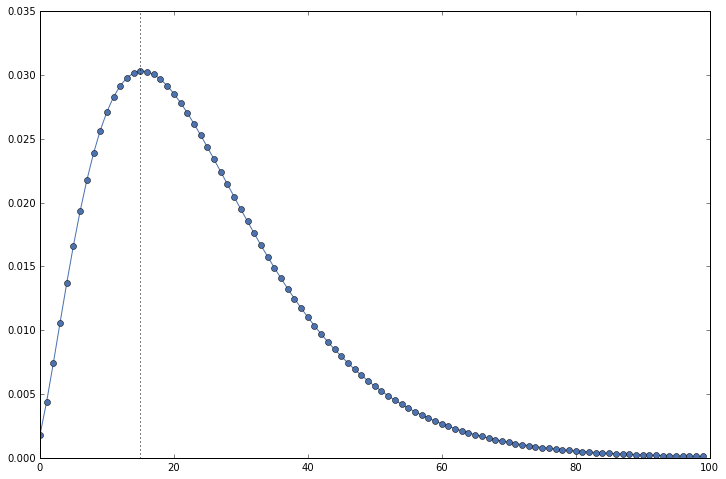

In [3]:
p = stats.nbinom(2.75, 0.1)

x = np.arange(100)
plt.plot(x, p.pmf(x), 'o-')
plt.axvline(15, c='k', ls=':')
np.sum(p.pmf(x))

(0.86229397403187025, 0.99999999999999989)

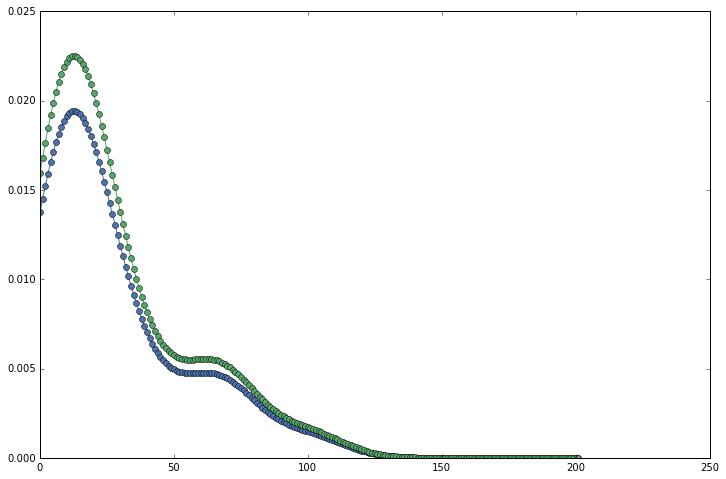

In [4]:
# check to see if the kde is normalized good enough on its own

samps = p.rvs(25)
counts = np.bincount(samps)

ps = counts / np.sum(counts)

gk = stats.gaussian_kde(samps, None)

xs = np.arange(len(counts)*2)

plt.plot(xs, gk(xs), 'o-')
egk = gk(xs) / np.sum(gk(xs))
plt.plot(xs, egk, 'o-')

np.sum(gk(xs)), np.sum(egk)

In [5]:
def sample_and_smooth(n, bw=None, renormalize=True):
    samps = p.rvs(n)
    
    counts = np.bincount(samps)
    xs = np.arange(len(counts)*2)
    ps = np.concatenate((counts, [0]*len(counts))) / np.sum(counts)

    gk = stats.gaussian_kde(samps, bw)
    smooth_ps = gk(xs)
    if renormalize:
        smooth_ps /= np.sum(smooth_ps)
    
    return xs, ps, smooth_ps

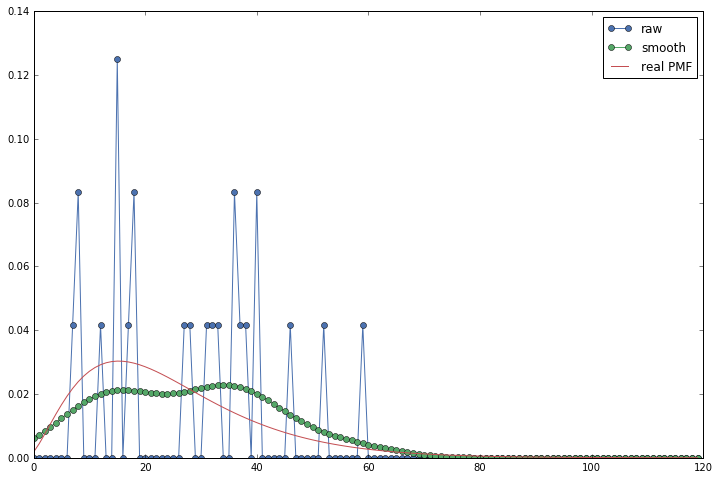

In [6]:
xs, ps, sps = sample_and_smooth(24)
plt.plot(xs, ps, 'o-', label='raw')
plt.plot(xs, sps, 'o-', label='smooth')
plt.plot(xs, p.pmf(xs), label='real PMF')

plt.legend(loc=0)

In [13]:
def make_sampling_plots(iters, nsamps, renormalize, xlims=(0, 25), pkwargs1={}, pkwargs2={}):
    raw_diffs = []
    smoothed_diffs = []
    raw_percs = []
    smoothed_percs = []

    maxxs = []
    
    for _ in range(iters):
        xs, ps, sps = sample_and_smooth(nsamps, renormalize=renormalize)
        if len(xs) > len(maxxs):
            maxxs = xs

        prop_cycle = iter(plt.rcParams['axes.prop_cycle'])
        for k,v in next(prop_cycle).items():
            pkwargs1.setdefault(k, v)
        for k,v in next(prop_cycle).items():
            pkwargs2.setdefault(k, v)
            
        for kw in (pkwargs1, pkwargs2):
            kw.setdefault('mew', 0)
            kw.setdefault('ms', 6)
            kw.setdefault('alpha', .01)
            kw.setdefault('fmt', 'o')
        fmt1 = pkwargs1.pop('fmt')
        fmt2 = pkwargs2.pop('fmt')
        

        raw_diffs.append(ps-p.pmf(xs))
        smoothed_diffs.append(sps-p.pmf(xs))

        plt.subplot(1,2,1)
        plt.plot(xs, raw_diffs[-1], fmt1, **pkwargs1)
        plt.plot(xs, smoothed_diffs[-1], fmt2, **pkwargs2)


        raw_percs.append(ps/p.pmf(xs)-1)
        smoothed_percs.append(sps/p.pmf(xs)-1)

        plt.subplot(1,2,2)
        plt.plot(xs, raw_percs[-1], fmt1, **pkwargs1)
        plt.plot(xs, smoothed_percs[-1], fmt2, **pkwargs2)


    plt.subplot(1,2,1)
    raw_diffs = np.array([np.concatenate((arr, [0]*(len(maxxs)-len(arr)))) for arr in raw_diffs])
    plt.plot(maxxs, np.mean(raw_diffs, axis=0),'-', lw=2, color=pkwargs1['color'])
    smoothed_diffs = np.array([np.concatenate((arr, [0]*(len(maxxs)-len(arr)))) for arr in smoothed_diffs])
    plt.plot(maxxs, np.mean(smoothed_diffs, axis=0), '-', lw=2, color=pkwargs2['color'])
    plt.axhline(0, ls='--', c='k')
    plt.xlim(*xlims)

    plt.subplot(1,2,2)
    raw_percs = np.array([np.concatenate((arr, [0]*(len(maxxs)-len(arr)))) for arr in raw_percs])
    plt.plot(maxxs, np.mean(raw_percs, axis=0),'-', lw=2, color=pkwargs1['color'])
    smoothed_percs = np.array([np.concatenate((arr, [0]*(len(maxxs)-len(arr)))) for arr in smoothed_percs])
    plt.plot(maxxs, np.mean(smoothed_percs, axis=0),'-', lw=2, color=pkwargs2['color'])
    plt.xlim(*xlims)
    plt.ylim(-1.1,15)
    plt.axhline(0, ls='--', c='k')

    plt.tight_layout()

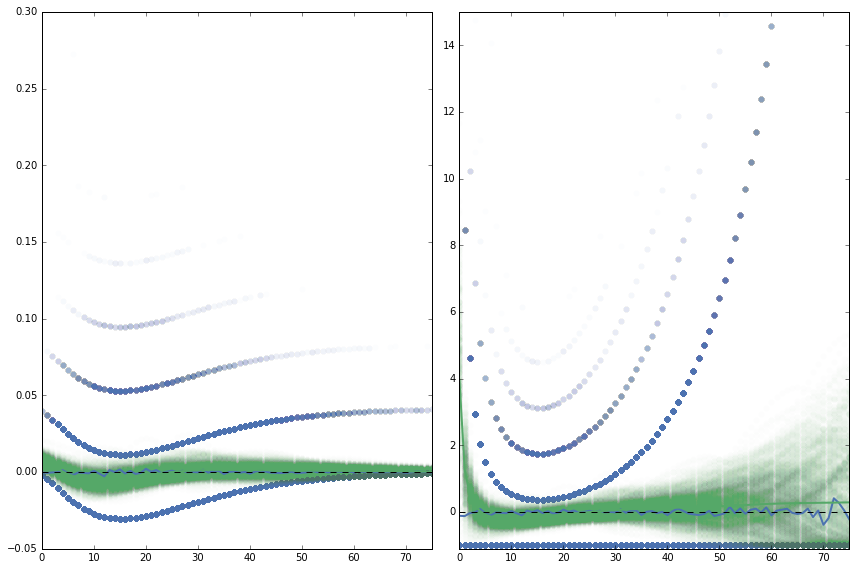

In [16]:
make_sampling_plots(1000, 24, True, xlims=(0, 75))

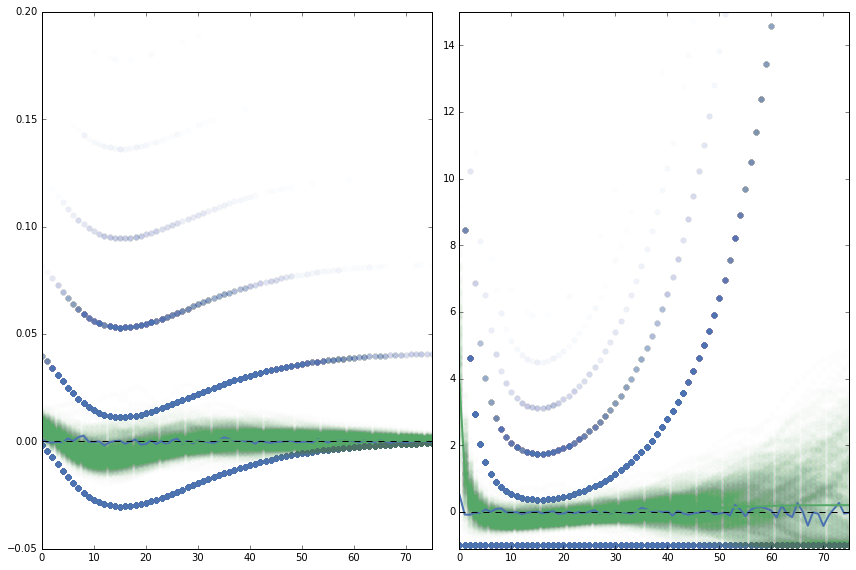

In [17]:
make_sampling_plots(1000, 24, False, xlims=(0, 75))

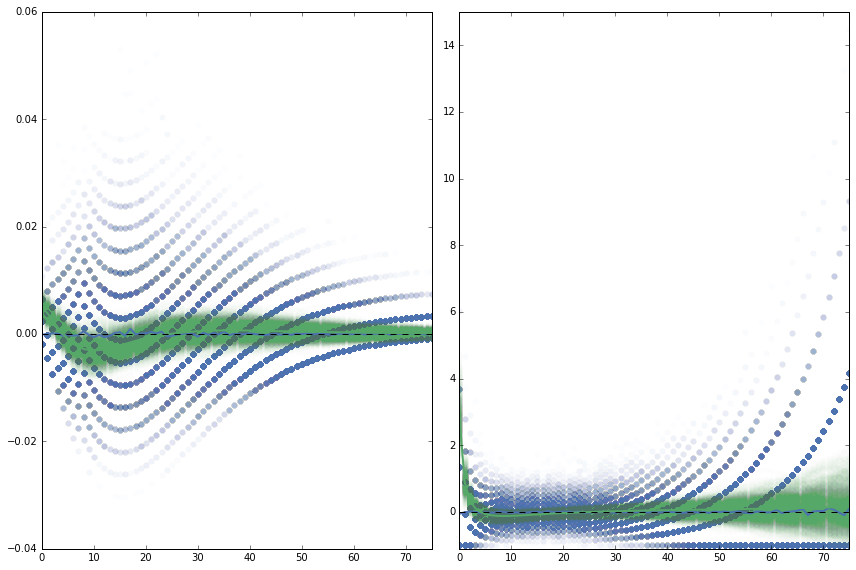

In [18]:
make_sampling_plots(1000, 240, True, xlims=(0, 75))

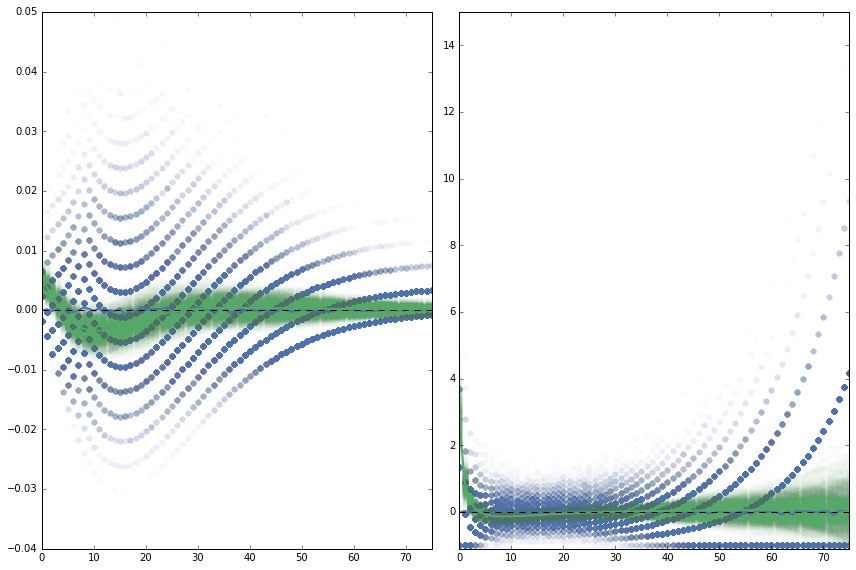

In [19]:
make_sampling_plots(1000, 240, False, xlims=(0, 75))